# 把split作为标准,评价gim的精度

In [1]:
!pwd

/scratch/eedy/liangcunren_alos2scan/alos2_d168_stack_5frames/notebook


In [10]:
from datetime import datetime
from mintpy.utils import ptime, readfile, writefile
import h5py
import numpy as np
from matplotlib import pyplot as plt, colorbar, ticker, colors
from mintpy.utils import ptime, readfile, writefile
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import subprocess
from mintpy.objects import timeseries
import math

In [11]:
# 定义文件路径
path_split = '../mintpy_split_ion_upsample/ion.h5'
path_GIM = '../mintpy_gim_ion_upsample/ion.h5'
path_hight_GIM = '../mintpy_hight_gim_ion_upsample/ion.h5'
path_cas = '../mintpy_cas_ion_upsample/ion.h5'
path_MIT = '../mintpy_MIT_gim_ion_upsample/ion.h5'
path_LIM = '../mintpy_LIM_ion_upsample/ion.h5'

## 1.设为同一参考点和参考时间

In [12]:
# 构建文件路径列表
file_paths = [path_split, path_GIM, path_hight_GIM, path_MIT, path_LIM, path_cas]

# 遍历文件路径列表，依次执行 reference_point.py 和 reference_date.py 命令
for file_path in file_paths:
    # 构建 reference_point.py 命令
    ref_point_command = ['reference_point.py', file_path, '-y', '400', '-x', '120']
    try:
        # 执行 reference_point.py 命令
        subprocess.run(ref_point_command, check=True)
        print(f"针对 {file_path} 执行 reference_point.py 命令成功")
    except subprocess.CalledProcessError as e:
        print(f"针对 {file_path} 执行 reference_point.py 命令失败: {e}")

    # 构建 reference_date.py 命令
    ref_date_command = ['reference_date.py', file_path, '--ref-date', '20181207']
    try:
        # 执行 reference_date.py 命令
        subprocess.run(ref_date_command, check=True)
        print(f"针对 {file_path} 执行 reference_date.py 命令成功")
    except subprocess.CalledProcessError as e:
        print(f"针对 {file_path} 执行 reference_date.py 命令失败: {e}")

--------------------------------------------------
input reference point in y/x: (400, 120)
--------------------------------------------------
SAME reference pixel is already selected/saved in file, skip updating.
针对 ../mintpy_split_ion_upsample/ion.h5 执行 reference_point.py 命令成功
input reference date: 20181207
--------------------------------------------------
change reference date for file: /scratch/eedy/liangcunren_alos2scan/alos2_d168_stack_5frames/mintpy_split_ion_upsample/ion.h5
input refDate is the same as the existing REF_DATE.
Nothing to be done.
time used: 00 mins 1.0 secs.
针对 ../mintpy_split_ion_upsample/ion.h5 执行 reference_date.py 命令成功
--------------------------------------------------
input reference point in y/x: (400, 120)
--------------------------------------------------
SAME reference pixel is already selected/saved in file, skip updating.
针对 ../mintpy_gim_ion_upsample/ion.h5 执行 reference_point.py 命令成功
input reference date: 20181207
-------------------------------------

## 2.读取ion的时间序列，用左上角右下角的值，获取距离和方位向坡度的时间序列

In [13]:
# 构建文件路径列表
file_paths = [path_split, path_GIM, path_hight_GIM, path_MIT, path_LIM, path_cas]
# 初始化存储 timeseries 数据的列表
timeseries_list = []
# 循环读取每个文件的 timeseries 数据并进行处理
for path in file_paths:
    time_series = readfile.read(path, datasetName='timeseries')[0]
    time_series = np.squeeze(time_series)
    timeseries_list.append(time_series)
# 将处理后的数据分别赋值给对应的变量
timeseries_split, timeseries_GIM, timeseries_hight_GIM, timeseries_MIT,timeseries_LIM,timeseries_cas  = timeseries_list

ts_file = '../mintpy_no_ion_upsample/timeseries_SET_ERA5_demErr.h5'
obj = timeseries(ts_file)
obj.open()
dates = ptime.date_list2vector(obj.dateList)[0]

time_series,art = readfile.read(path_split, datasetName='timeseries')
a_piexl = float(art['AZIMUTH_PIXEL_SIZE'])
r_piexl = float(art['RANGE_PIXEL_SIZE'])

open timeseries file: timeseries_SET_ERA5_demErr.h5


# 3.计算vtec强度

In [76]:
from mintpy.simulation import iono
from mintpy import iono_tec
from mintpy.objects import ionex
from mintpy.objects import timeseries
from mintpy.utils import readfile

# 定义数据路径
tec_dir = '/home/eedy/data/aux/IONEX'
geom_file = '../mintpy_no_ion_upsample/geo/geo_geometryRadar.h5'
ts_file = '../mintpy_no_ion_upsample/timeseries_SET_ERA5_demErr.h5'

# 获取日期列表
date_list = timeseries(ts_file).get_date_list()

# 读取元数据
meta = readfile.read_attribute(ts_file)
utc_sec = float(meta['CENTER_LINE_UTC'])

# 下载 IONEX 文件
tec_files = iono_tec.download_ionex_files(date_list, tec_dir, sol_code='jpl')

# 准备电离层几何信息
iono_inc_angle, iono_lat, iono_lon, iono_height = iono.prep_geometry_iono(geom_file, box=None, iono_height=450e3, print_msg=True)

# 初始化 vtec 列表
vtec = []

# 遍历每个 IONEX 文件
for tec_file in tec_files:
    # 获取电离层总电子含量 (VTEC) 值
    vtec_value = ionex.get_ionex_value(tec_file, utc_sec, lat=40.5139, lon=-119.7465, interp_method='linear3d', rotate_tec_map=True, print_msg=True)
    # 将 VTEC 值添加到列表中
    vtec.append(vtec_value)


------------------------------------------------------------------------------
downloading GNSS-based TEC products in IONEX format from NASA/CDDIS ...
https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/atmospheric_products.html
number of TEC files to download: 32
local TEC file directory: /home/eedy/data/aux/IONEX
ALL files exists with consistent file size (~840 KB) --> skip re-downloading.

incidence angle on the ground     min/max: 25.4/49.3 deg
incidence angle on the ionosphere min/max: 23.6/45.1 deg
center lat/lon  on the ground    : 40.5139/-119.7465 deg
center lat/lon  on the ionosphere: 39.9407/-115.9634 deg


/tmp/ipykernel_3917382/2556674776.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


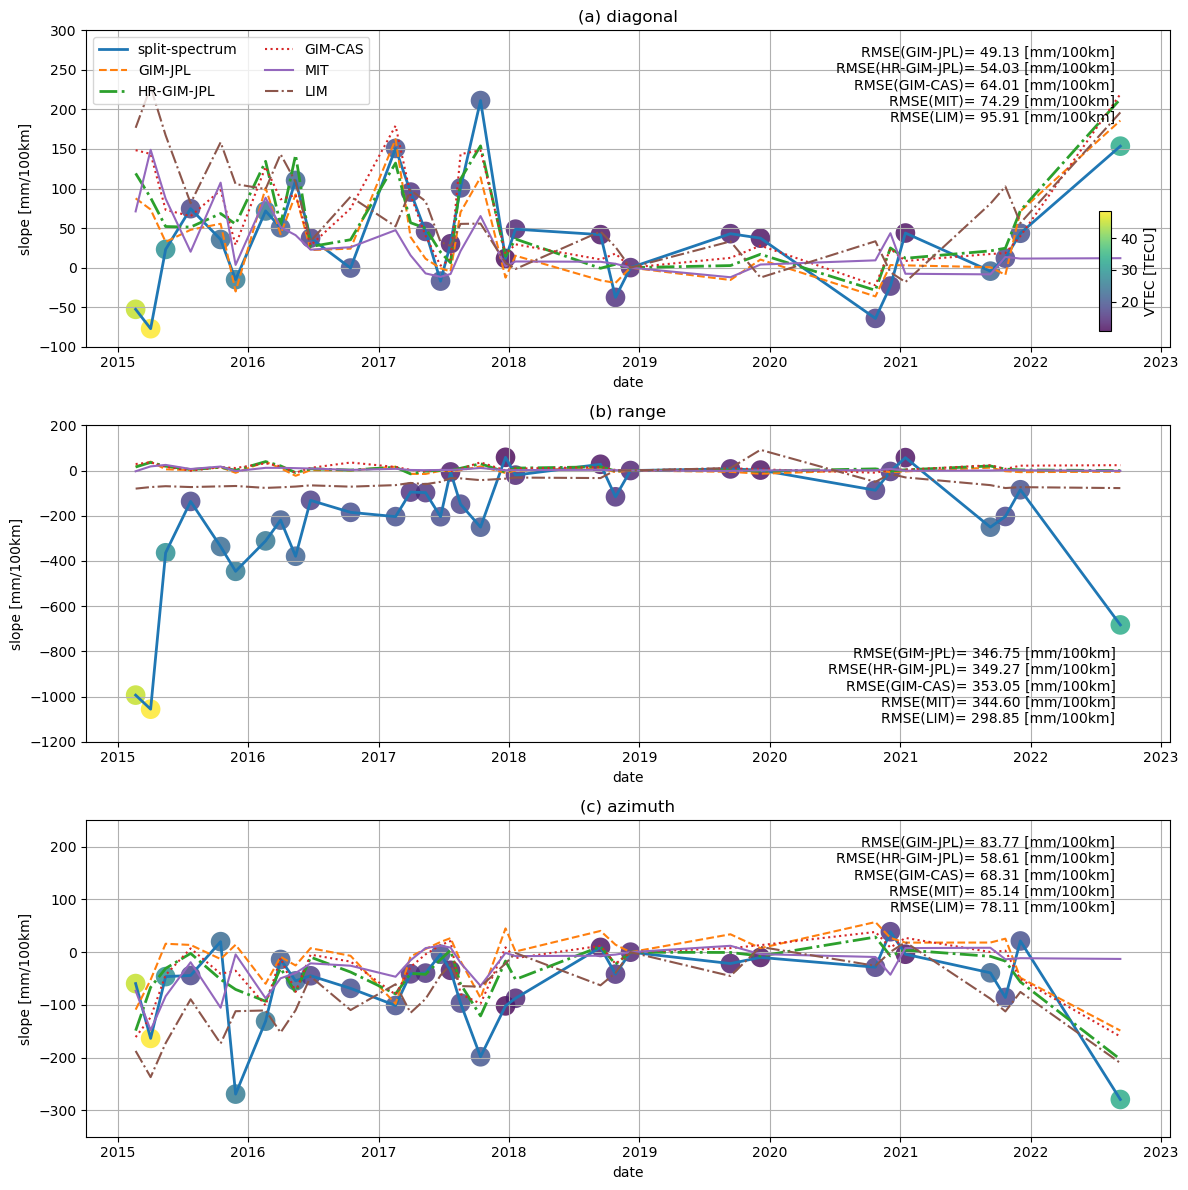

In [84]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def calculate_diff_and_plot(ax, x1, y1, x2, y2, title, ylim, text_position='upper right'):
    # 计算两点间的实际物理距离
    distance = math.sqrt((abs(x1 - x2) * r_piexl) ** 2 + (abs(y1 - y2) * a_piexl) ** 2)
    # 计算每个数据集在两个点的差值的时间序列
    diff_split = timeseries_split[:, y1, x1] - timeseries_split[:, y2, x2]
    diff_split = diff_split / distance * 1e8
    diff_GIM = timeseries_GIM[:, y1, x1] - timeseries_GIM[:, y2, x2]
    diff_GIM = diff_GIM / distance * 1e8
    diff_hight_GIM = timeseries_hight_GIM[:, y1, x1] - timeseries_hight_GIM[:, y2, x2]
    diff_hight_GIM = diff_hight_GIM / distance * 1e8
    diff_MIT = timeseries_MIT[:, y1, x1] - timeseries_MIT[:, y2, x2]
    diff_MIT = diff_MIT / distance * 1e8
    diff_LIM = timeseries_LIM[:, y1, x1] - timeseries_LIM[:, y2, x2]
    diff_LIM = diff_LIM / distance * 1e8
    diff_cas = timeseries_cas[:, y1, x1] - timeseries_cas[:, y2, x2]
    diff_cas = diff_cas / distance * 1e8

    # 定义颜色和线条样式
    linestyles = ['-', '--', '-.', ':', '-', '-.']

    # 在子图中绘制时间序列
    line1, = ax.plot(dates, diff_split, label='split-spectrum', linestyle=linestyles[0], linewidth=2)
    line2, = ax.plot(dates, diff_GIM, label='GIM-JPL', linestyle=linestyles[1])
    line3, = ax.plot(dates, diff_hight_GIM, label='HR-GIM-JPL', linestyle=linestyles[2], linewidth=2)
    line4, = ax.plot(dates, diff_cas, label='GIM-CAS', linestyle=linestyles[3])
    line5, = ax.plot(dates, diff_MIT, label='MIT', linestyle=linestyles[4])
    line6, = ax.plot(dates, diff_LIM, label='LIM', linestyle=linestyles[5])

    ax.set_title(title)
    ax.set_xlabel('date')
    ax.set_ylabel('slope [mm/100km]')
    ax.grid(True)

    # 计算RMSE
    rmse_GIM = np.sqrt(mean_squared_error(diff_split, diff_GIM))
    rmse_hight_GIM = np.sqrt(mean_squared_error(diff_split, diff_hight_GIM))
    rmse_cas = np.sqrt(mean_squared_error(diff_split, diff_cas))
    rmse_MIT = np.sqrt(mean_squared_error(diff_split, diff_MIT))
    rmse_LIM = np.sqrt(mean_squared_error(diff_split, diff_LIM))

    # 在指定位置添加RMSE和R2文本
    textstr_GIM = (f'RMSE(GIM-JPL)= {rmse_GIM:.2f} [mm/100km]')
    textstr_hight_GIM = (f'RMSE(HR-GIM-JPL)= {rmse_hight_GIM:.2f} [mm/100km]')
    textstr_MIT = (f'RMSE(MIT)= {rmse_MIT:.2f} [mm/100km]')
    textstr_LIM = (f'RMSE(LIM)= {rmse_LIM:.2f} [mm/100km]')
    textstr_cas = (f'RMSE(GIM-CAS)= {rmse_cas:.2f} [mm/100km]')
    if text_position == 'upper right':
        ax.text(0.95, 0.95, textstr_GIM + '\n' + textstr_hight_GIM + '\n' +  textstr_cas + '\n' + textstr_MIT + '\n' + textstr_LIM ,
                transform=ax.transAxes, va='top', ha='right')
    elif text_position == 'lower right':
        ax.text(0.95, 0.05,  textstr_GIM + '\n' + textstr_hight_GIM + '\n' +  textstr_cas + '\n' + textstr_MIT + '\n' + textstr_LIM ,
                transform=ax.transAxes, va='bottom', ha='right')

    # 设置y轴范围
    ax.set_ylim(ylim)

    return diff_split, diff_GIM, diff_hight_GIM, diff_MIT, diff_LIM, diff_cas, dates

# 创建主图形并调整布局，变为3行1列的子图布局
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# 定义每个子图的y轴范围
y_limits = [(-100, 300), (-1200, 200), (-350, 250)]

# 初始化变量保存所有子图的数据
diff_split_list = []
dates_list = []

# 绘制子图
for i, (x1, y1, x2, y2, title) in enumerate([(50, 600, 200, 70, '(a) diagonal'),
                                              (50, 600, 200, 600, '(b) range'),
                                              (200, 60, 200, 70, '(c) azimuth')]):
    # 调用函数并获取返回值
    result = calculate_diff_and_plot(axes[i], x1, y1, x2, y2, title, y_limits[i], 
                                    text_position='lower right' if i == 1 else 'upper right')
    diff_split, _, _, _, _, _, dates = result
    diff_split_list.append(diff_split)
    dates_list.append(dates)

    # 在每个子图上叠加VTEC散点
    # 确保vtec是numpy数组
    vtec_array = np.array(vtec)
    # 创建散点图，颜色对应VTEC值
    sc = axes[i].scatter(dates, diff_split, c=vtec_array, 
                         cmap='viridis', s=200, alpha=0.8, edgecolors='none')

# 只在第一个子图绘制折线的legend且分成两列显示
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='upper left', ncol=2)

# 创建一个新的axes用于放置colorbar
cbar_ax = fig.add_axes([0.92, 0.72, 0.01, 0.1])
# 图的右边统一画一个colorbar
sc = axes[0].scatter(dates, diff_split, c=vtec_array, cmap='viridis', alpha=0.8,s=0)  # 创建一个虚拟的散点图用于colorbar
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('VTEC [TECU]')

# 调整布局
plt.tight_layout()
plt.savefig('ion_ramp_alos.pdf', bbox_inches='tight', transparent=True, dpi=600)
plt.show()